# ==============================
# COVID-19 Radiography Classification + Grad-CAM
# ==============================

In [1]:
!pip install -q kagglehub

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import cv2
import kagglehub

# 1️⃣ Define dataset paths

In [3]:
path = kagglehub.dataset_download(
    "tawsifurrahman/covid19-radiography-database"
)
data_dir = os.path.join(path, "COVID-19_Radiography_Dataset")
print("Classes found:", os.listdir(data_dir))

Using Colab cache for faster access to the 'covid19-radiography-database' dataset.
Classes found: ['Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'README.md.txt', 'COVID.metadata.xlsx', 'Normal', 'Lung_Opacity', 'Viral Pneumonia.metadata.xlsx', 'Viral Pneumonia', 'COVID']


In [4]:
def define_paths(data_dir):
    filepaths, labels = [], []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path): continue
        for sub in os.listdir(class_path):
            if sub.lower() == "masks": continue
            sub_path = os.path.join(class_path, sub)
            if os.path.isdir(sub_path):
                for img in os.listdir(sub_path):
                    filepaths.append(os.path.join(sub_path, img))
                    labels.append(class_name)
            else:
                filepaths.append(sub_path)
                labels.append(class_name)
    return filepaths, labels

def define_df(files, labels):
    return pd.DataFrame({"filepaths": files, "labels": labels})

def split_data(data_dir):
    files, labels = define_paths(data_dir)
    df = define_df(files, labels)
    train_df, temp_df = train_test_split(df, train_size=0.8, stratify=df["labels"], random_state=123)
    val_df, test_df = train_test_split(temp_df, train_size=0.5, stratify=temp_df["labels"], random_state=123)
    return train_df, val_df, test_df

train_df, val_df, test_df = split_data(data_dir)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 16932, Val: 2116, Test: 2117


# 2️⃣ Create data generators

In [5]:
def create_gens(train_df, val_df, test_df, batch_size=16):
    img_size = (224, 224)
    train_gen = ImageDataGenerator(horizontal_flip=True)
    val_gen = ImageDataGenerator()
    test_gen = ImageDataGenerator()

    train = train_gen.flow_from_dataframe(train_df, x_col="filepaths", y_col="labels",
                                          target_size=img_size, class_mode="categorical",
                                          batch_size=batch_size, shuffle=True)
    val = val_gen.flow_from_dataframe(val_df, x_col="filepaths", y_col="labels",
                                      target_size=img_size, class_mode="categorical",
                                      batch_size=batch_size, shuffle=True)
    test = test_gen.flow_from_dataframe(test_df, x_col="filepaths", y_col="labels",
                                        target_size=img_size, class_mode="categorical",
                                        batch_size=batch_size, shuffle=False)
    return train, val, test

train_gen, val_gen, test_gen = create_gens(train_df, val_df, test_df)
class_count = len(train_gen.class_indices)
classes = list(train_gen.class_indices.keys())
print("Classes:", train_gen.class_indices)

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.
Classes: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


# 3️⃣ Build model

In [6]:
inputs = Input(shape=(224,224,3))
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=inputs)
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
outputs = Dense(class_count, activation="softmax")(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# 4️⃣ Train model

In [7]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3)
]

EPOCHS = 10
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 141s 100ms/step - accuracy: 0.6986 - loss: 2.5079 - val_accuracy: 0.8303 - val_loss: 1.2446 - learning_rate: 1.0000e-04
Epoch 2/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 68s 64ms/step - accuracy: 0.8126 - loss: 1.1628 - val_accuracy: 0.8455 - val_loss: 0.8308 - learning_rate: 1.0000e-04
Epoch 3/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 68s 64ms/step - accuracy: 0.8397 - loss: 0.8126 - val_accuracy: 0.8611 - val_loss: 0.6597 - learning_rate: 1.0000e-04
Epoch 4/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 67s 63ms/step - accuracy: 0.8511 - loss: 0.6670 - val_accuracy: 0.8691 - val_loss: 0.5780 - learning_rate: 1.0000e-04
Epoch 5/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 66s 63ms/step - accuracy: 0.8573 - loss: 0.5986 - val_accuracy: 0.8629 - val_loss: 0.5306 - learning_rate: 1.0000e-04
Epoch 6/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 66s 63ms/step - accuracy: 0.8588 - loss: 0.5584 - val_accuracy: 0.8644 - val_loss: 0.5036 - learning_rate: 1.0000e-04
Epoch 7/10
1059/1059 ━━━━━━━━━━━━━━━━━

# 5️⃣ Plot training history

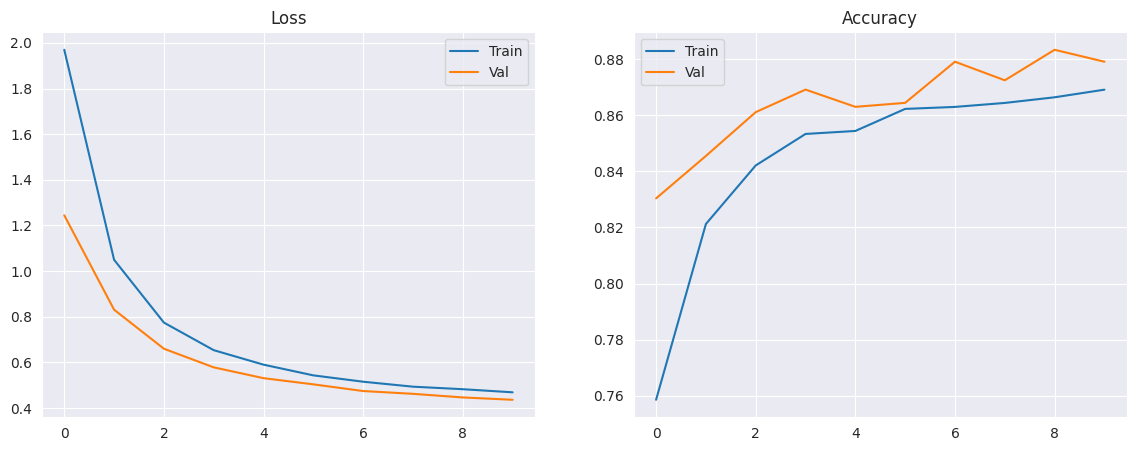

In [8]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()
plt.show()

# 6️⃣ Evaluate on test set

133/133 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 0.8851 - loss: 0.4042
Test Accuracy: 0.8927727937698364
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step


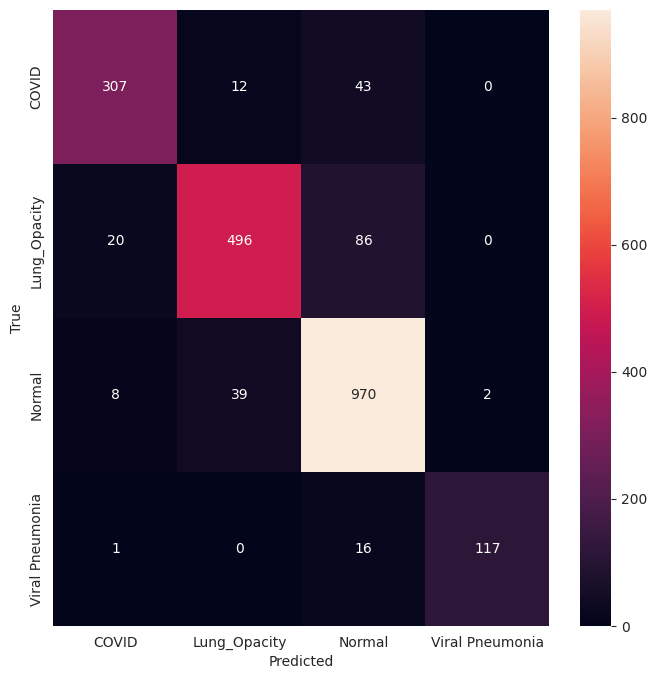

                 precision    recall  f1-score   support

          COVID       0.91      0.85      0.88       362
   Lung_Opacity       0.91      0.82      0.86       602
         Normal       0.87      0.95      0.91      1019
Viral Pneumonia       0.98      0.87      0.92       134

       accuracy                           0.89      2117
      macro avg       0.92      0.87      0.89      2117
   weighted avg       0.90      0.89      0.89      2117



In [9]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(test_gen.classes, y_pred, target_names=classes))

# 7️⃣ Save model

In [10]:
model.save("covid_efficientnetb0_grad_cam.keras")
print("Model saved")

Model saved


# 8️⃣ Grad-CAM functions

In [11]:
def make_gradcam_heatmap(img_array, grad_model, pred_index=None):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    if max_val > 0:
        heatmap /= max_val
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlayed = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    return np.clip(overlayed, 0, 255).astype(np.uint8)

# 9️⃣ Grad-CAM visualization

In [16]:
def find_layer(model, layer_name):
    """
    Recursively search for a layer by name in nested models.
    """
    for layer in model.layers:
        if layer_name.lower() in layer.name.lower():
            return layer
        # If the layer is a Model, search inside it
        if isinstance(layer, tf.keras.Model):
            found = find_layer(layer, layer_name)
            if found is not None:
                return found
    return None


In [17]:
def visualize_gradcam(img_path, model, class_names, last_conv_layer_name="top_conv"):
    # Find the last conv layer in EfficientNetB0
    conv_layer = find_layer(model, last_conv_layer_name)
    if conv_layer is None:
        raise ValueError(f"Conv layer '{last_conv_layer_name}' not found")

    # Build grad_model
    grad_model = Model(inputs=model.input, outputs=[conv_layer.output, model.output])

    # Load and preprocess image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224,224))
    img_array = np.expand_dims(img_resized / 255.0, axis=0).astype(np.float32)

    # Predict
    preds = model.predict(img_array)
    pred_class = np.argmax(preds[0])
    confidence = preds[0][pred_class]

    # Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, grad_model, pred_index=pred_class)
    gradcam_img = overlay_gradcam(img_rgb, heatmap)

    plt.figure(figsize=(6,6))
    plt.imshow(gradcam_img)
    plt.title(f"Pred: {class_names[pred_class]} ({confidence*100:.2f}%)")
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


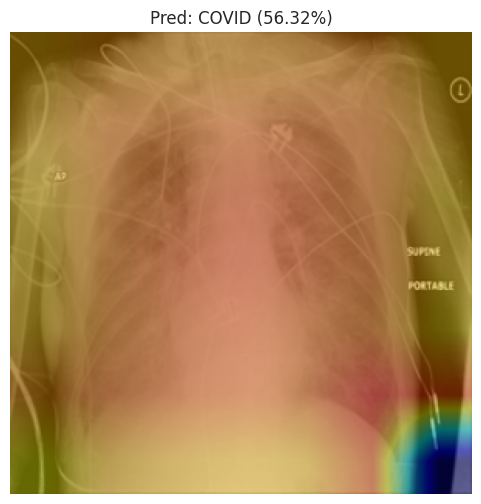

In [18]:
test_image_path = test_df.iloc[0]["filepaths"]
visualize_gradcam(test_image_path, model, classes)